<a href="https://colab.research.google.com/github/Redcoder815/Machine_Learning/blob/main/DecisionTreeClassifierScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training accuracy: 1.0


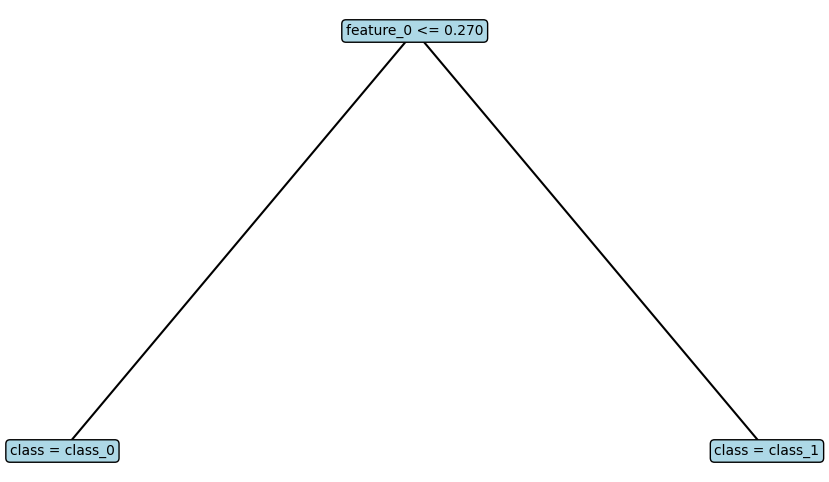

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import ipdb

def entropy(y):
    """
    Compute entropy of a label array y.
    y: array-like of shape (n_samples,)
    """
    # Count occurrences of each class
    counts = np.bincount(y)
    probabilities = counts[counts > 0] / len(y)

    # H = -sum p * log2(p)
    return -np.sum(probabilities * np.log2(probabilities))


def information_gain(y, y_left, y_right):
    """
    Compute information gain of a split:
    IG = H(parent) - (n_L/n * H(left) + n_R/n * H(right))
    """
    H_parent = entropy(y)

    n = len(y)
    n_left = len(y_left)
    n_right = len(y_right)

    if n_left == 0 or n_right == 0:
        # No actual split
        return 0

    H_left = entropy(y_left)
    H_right = entropy(y_right)

    weighted_child_entropy = (n_left / n) * H_left + (n_right / n) * H_right

    return H_parent - weighted_child_entropy

class TreeNode:
    def __init__(self,
                 feature_index=None,
                 threshold=None,
                 left=None,
                 right=None,
                 value=None):
        """
        If value is not None, this is a leaf node.
        Otherwise, it is a decision node, with feature_index and threshold.
        """
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # class label for leaf

class DecisionTreeClassifierScratch:
    def __init__(self,
                 max_depth=None,
                 min_samples_split=2,
                 min_impurity_decrease=1e-7):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.root = None

    def fit(self, X, y):
        """
        Build the decision tree from training data.
        X: numpy array of shape (n_samples, n_features)
        y: numpy array of shape (n_samples,)
        """
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        # ipdb.set_trace(context=10)
        self.root = self._build_tree(X, y, depth=0)
        return self

    def _build_tree(self, X, y, depth):
        """
        Recursively build the decision tree.
        """
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        # Stopping conditions:
        # 1. Pure node (all labels the same)
        # 2. Not enough samples to split
        # 3. Reached max depth
        if (num_labels == 1 or
            num_samples < self.min_samples_split or
            (self.max_depth is not None and depth >= self.max_depth)):
            leaf_value = self._most_common_label(y)
            # ipdb.set_trace(context = 10)
            return TreeNode(value=leaf_value)

        # Find the best split: feature and threshold
        best_feature, best_threshold, best_gain = self._best_split(X, y)

        # If no useful split (gain too small), create leaf
        if best_gain < self.min_impurity_decrease:
            leaf_value = self._most_common_label(y)
            return TreeNode(value=leaf_value)

        # Split
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[right_indices], y[right_indices]

        # Recursively build children
        left_child = self._build_tree(X_left, y_left, depth + 1)
        right_child = self._build_tree(X_right, y_right, depth + 1)

        # Return decision node
        return TreeNode(feature_index=best_feature,
                        threshold=best_threshold,
                        left=left_child,
                        right=right_child)

    def _best_split(self, X, y):
        """
        Try all features and candidate thresholds and return the best split.
        """
        num_samples, num_features = X.shape
        best_gain = -1
        best_feature = None
        best_threshold = None

        for feature_index in range(num_features):
            # Consider unique values of this feature as candidate thresholds
            feature_values = X[:, feature_index]
            unique_values = np.unique(feature_values)

            # Optionally, we could consider midpoints between sorted unique values.
            # For simplicity, let's use unique_values directly as thresholds.
            for threshold in unique_values:
                left_indices = feature_values <= threshold
                right_indices = feature_values > threshold

                y_left = y[left_indices]
                y_right = y[right_indices]

                gain = information_gain(y, y_left, y_right)

                if gain > best_gain:
                    # ipdb.set_trace(context=10)
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _most_common_label(self, y):
        """
        Return the most frequent class label in y.
        """
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        """
        Predict class labels for samples in X.
        """
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        """
        Traverse the tree from the root to a leaf for sample x.
        """
        # If leaf
        if node.value is not None:
            return node.value

        # Go left or right depending on threshold
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

# Simple toy dataset
np.random.seed(0)

# Class 0
X0 = np.random.randn(50, 2) + np.array([-2, 0])
y0 = np.zeros(50, dtype=int)

# Class 1
X1 = np.random.randn(50, 2) + np.array([2, 0])
y1 = np.ones(50, dtype=int)

X = np.vstack([X0, X1])
y = np.concatenate([y0, y1])

# Shuffle
indices = np.random.permutation(len(y))
X = X[indices]
y = y[indices]

# Fit our decision tree
tree = DecisionTreeClassifierScratch(max_depth=3, min_samples_split=2)
tree.fit(X, y)

# Predict on training data (for demo)
y_pred = tree.predict(X)
accuracy = np.mean(y_pred == y)
print("Training accuracy:", accuracy)

def plot_tree(node, feature_names=None, class_names=None):
    """
    Plot the decision tree using matplotlib in a simple text-based way.
    feature_names: list of feature names (optional)
    class_names: list of class names (optional, index by label)
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_axis_off()

    # Compute positions of nodes
    x, y = 0.5, 1.0  # root position
    _plot_node(ax, node, x, y, x_range=0.5, feature_names=feature_names, class_names=class_names)
    plt.show()


def _plot_node(ax, node, x, y, x_range, feature_names=None, class_names=None, depth=0):
    """
    Recursive helper to draw a node and its children.
    x, y: position of the current node
    x_range: horizontal half-range allocated to this subtree
    """
    # Draw current node as a box with text
    if node.value is not None:
        # Leaf
        if class_names is not None:
            label_text = f"class = {class_names[node.value]}"
        else:
            label_text = f"class = {node.value}"
    else:
        # Decision node
        if feature_names is not None:
            feat_name = feature_names[node.feature_index]
        else:
            feat_name = f"X[{node.feature_index}]"
        label_text = f"{feat_name} <= {node.threshold:.3f}"

    bbox_props = dict(boxstyle="round,pad=0.3", fc="lightblue", ec="black", lw=1)
    ax.text(x, y, label_text, ha="center", va="center", bbox=bbox_props)

    # If leaf, stop
    if node.value is not None:
        return

    # Draw children
    y_child = y - 0.12  # vertical step down

    # Left child
    x_left = x - x_range
    ax.plot([x, x_left], [y, y_child], color="black")
    _plot_node(ax, node.left, x_left, y_child, x_range * 0.5,
               feature_names=feature_names, class_names=class_names, depth=depth+1)

    # Right child
    x_right = x + x_range
    ax.plot([x, x_right], [y, y_child], color="black")
    _plot_node(ax, node.right, x_right, y_child, x_range * 0.5,
               feature_names=feature_names, class_names=class_names, depth=depth+1)


feature_names = ["feature_0", "feature_1"]
class_names = ["class_0", "class_1"]

plot_tree(tree.root, feature_names=feature_names, class_names=class_names)
